In [1]:
import pandas as pd
import numpy as np
import sklearn.tree as tree
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os.path
from os import path
from sklearn.model_selection import KFold
from multiprocessing import Process, Manager, SimpleQueue
import multiprocessing
import shutil
import sys
import time
from sklearn.metrics import accuracy_score
from rules import *
from vote import *
from save_amie_data import *
from precision import *
from amie import *

root = "./../../ST_Tree_constant/"
cv = 3
limit_tree = 0.7

colors_to_print = ["red",  "blue", "orange",  "violet", "darkgrey", "darkred", "darkblue", "darkorange", "darkviolet", "grey"]

# 1° Load data

In [2]:
data = pd.read_csv("./../Data/miniloan-decisions-100K.csv")

In [3]:
data

,name,creditScore,income,loanAmount,monthDuration,rate,approval,yearlyReimbursement
0,John Doe,736,113243,783440,162,0.030005,false,70648
1,John Doe,527,224186,1787385,183,0.054819,false,173197
2,John Doe,460,39954,1733494,75,0.055183,false,328563
3,John Doe,751,219998,1350004,72,0.043400,false,255970
4,John Doe,684,72470,1210944,160,0.037772,false,115742
...,...,...,...,...,...,...,...,...
99995,John Doe,366,83851,1718571,168,0.053737,false,174928
99996,John Doe,395,184259,1599473,90,0.040564,false,247703
99997,John Doe,674,242620,1099790,260,0.040825,false,76557
99998,John Doe,420,180957,1645870,203,0.049558,false,143897


# Ratios

In [4]:
ratio_names = [("income","yearlyReimbursement"), ("income","loanAmount"), ("loanAmount","rate")]

In [5]:
# Takes two features and will create the ratio f_0/f_1
def create_features_ratio(data):
    if data[data.index[1]] == 0:
        return 2147483647
    return np.round(data[data.index[0]]/data[data.index[1]], decimals=2)

In [6]:
for ratio_name in ratio_names:
    data[f"{ratio_name[0]}/{ratio_name[1]}"] = data[[ratio_name[0], ratio_name[1]]].apply(create_features_ratio, axis=1)

In [7]:
data

,name,creditScore,income,loanAmount,monthDuration,rate,approval,yearlyReimbursement,income/yearlyReimbursement,income/loanAmount,loanAmount/rate
0,John Doe,736,113243,783440,162,0.030005,false,70648,1.60,0.14,26110372.80
1,John Doe,527,224186,1787385,183,0.054819,false,173197,1.29,0.13,32605003.59
2,John Doe,460,39954,1733494,75,0.055183,false,328563,0.12,0.02,31413368.70
3,John Doe,751,219998,1350004,72,0.043400,false,255970,0.86,0.16,31106073.81
4,John Doe,684,72470,1210944,160,0.037772,false,115742,0.63,0.06,32059172.14
...,...,...,...,...,...,...,...,...,...,...,...
99995,John Doe,366,83851,1718571,168,0.053737,false,174928,0.48,0.05,31981153.44
99996,John Doe,395,184259,1599473,90,0.040564,false,247703,0.74,0.12,39430859.20
99997,John Doe,674,242620,1099790,260,0.040825,false,76557,3.17,0.22,26938940.88
99998,John Doe,420,180957,1645870,203,0.049558,false,143897,1.26,0.11,33211031.24


# 2° Find the best thresholds

In [8]:
data_raw = data.drop(columns=["name"])
false_data = data_raw[data_raw["approval"] == " false"]
true_data = data_raw[data_raw["approval"] == " true"]

nb_launch_tree = 10

In [9]:
%%time

def returnSplitValue(stringToSplit):
    res = []
    tp = ""
    spliters = [("lt", "< "), ("lte", "<= "), ("gt", "> "), ("gte", ">= ")]
    i=0
    
    while i < len(spliters):
        splited = stringToSplit.split(spliters[i][1]) 
        if len(splited) == 2:
            return  spliters[i][0], float(splited[1])
        i += 1
    print("C'est casse")
    return None 


best_threshold = []
for key in data.drop(columns=["name"]).columns:
    if key != "approval":
        res_accuracy_train = []
        res_accuracy_test = []
        model = None
        print("\t\t"+key)
        for i in range(nb_launch_tree):
            data_equilibrium = true_data.append(false_data.sample(n=len(true_data)))
            X = data_equilibrium[[key]]

            Y = data_equilibrium["approval"]

            X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33)

            model = tree.DecisionTreeClassifier(max_depth=1)
            model.fit(X_train, y_train)    
            
            res_accuracy_train.append(accuracy_score(y_train, model.predict(X_train)))
            res_accuracy_test.append(accuracy_score(y_test, model.predict(X_test)))
        print(f"Train Score : {np.mean(res_accuracy_train)}")
        print(f"Test Score : {np.mean(res_accuracy_test)}")

        if np.mean(res_accuracy_train) > limit_tree and np.mean(res_accuracy_test) > limit_tree:
            best_threshold.append((key,)+ returnSplitValue(tree.export_text(model, spacing=1, feature_names=[key]).split("\n")[0]))
print(best_threshold)

		creditScore
Train Score : 0.5051023183085187
Test Score : 0.4995169082125604
		income
Train Score : 0.6447651097967231
Test Score : 0.6442305037957212
		loanAmount
Train Score : 0.8428785097559318
Test Score : 0.8411042097998619
		monthDuration
Train Score : 0.610588755183901
Test Score : 0.6077156659765356
		rate
Train Score : 0.5117615065606091
Test Score : 0.5089648033126294
		yearlyReimbursement
Train Score : 0.8987456659188252
Test Score : 0.8998136645962733
		income/yearlyReimbursement
Train Score : 0.9930994629138624
Test Score : 0.9931262939958593
		income/loanAmount
Train Score : 0.9236351893398599
Test Score : 0.9230089717046237
		loanAmount/rate
Train Score : 0.8276497382554897
Test Score : 0.8251483781918564
[('loanAmount', 'lte', 840180.0), ('yearlyReimbursement', 'lte', 66959.5), ('income/yearlyReimbursement', 'lte', 3.33), ('income/loanAmount', 'lte', 0.24), ('loanAmount/rate', 'lte', 17643189.0)]
CPU times: user 8.53 s, sys: 0 ns, total: 8.53 s
Wall time: 8.53 s


# 3° Create the thresholds

Define the thresholds

In [10]:
thresholds = np.arange(0.25,1,0.25) #[0.25, 0.50, 0.75]
thresholds_str = [(str(i) for i in range(len(thresholds)))]

In [11]:
# Takes a dataframe and return the values per percents for each feature
def description_per_thresholds(data, percents):
    thresholds_Dic =  {}
    for column in data.columns:
        serie = data[column]
        thresholds_Dic[column] = serie.quantile(percents)
        
    return pd.DataFrame.from_dict(thresholds_Dic)

In [12]:
columns = list(data.drop(columns=["name", "approval"]).columns)

groupsDF = pd.DataFrame()

for column, comparator, value in best_threshold:
    groupsDF[column] = data[column].map(lambda x : 0 if x < value else 1)
    columns.remove(column)

In [13]:
description = description_per_thresholds(data[columns], thresholds)

Transform the data from integer values to boolean values corresponding to GTE or LTE with the different percents.

In [14]:
def attribute_group(value, description):
    for i, index in enumerate(description.index):
        if value <= description[index]:
            return i 
    return i+1

In [15]:
%%time

for column in columns:
    groupsDF[column] = data[column].map(lambda x : attribute_group(x, description[column]))

CPU times: user 6.8 s, sys: 15.6 ms, total: 6.81 s
Wall time: 6.81 s


In [16]:
groupsDF["approval"] = data["approval"].map({' true': True, ' false': False})
groupsDF

,loanAmount,yearlyReimbursement,income/yearlyReimbursement,income/loanAmount,loanAmount/rate,creditScore,income,monthDuration,rate,approval
0,0,1,0,0,1,3,1,1,0,False
1,1,1,0,0,1,1,2,2,3,False
2,1,1,0,0,1,1,0,0,3,False
3,1,1,0,0,1,3,2,0,1,False
4,1,1,0,0,1,2,0,1,1,False
...,...,...,...,...,...,...,...,...,...,...
99995,1,1,0,0,1,0,1,1,3,False
99996,1,1,0,0,1,0,2,0,1,False
99997,1,1,0,0,1,2,3,2,1,False
99998,1,1,0,0,1,0,2,2,2,False


Create the folder where the data will be stored.

In [17]:
if not path.isdir(root):
    os.mkdir(root)
    os.mkdir(root+"/Save_raw")
else : 
    shutil.rmtree(root)
    os.mkdir(root)
    os.mkdir(root+"/Save_raw")

In [18]:
groupsDF.to_csv(root+"dfSave.csv")

# 4° Save the best data

We store the data in the Amie format. 

In [19]:
save_all_data(root, groupsDF, integer=False)

## Save in cross validation

In [20]:
save_CV(root, groupsDF, cv, integer=False)

Train repartition :
 False    52004
True     14662
Name: approval, dtype: int64
Train repartition :
 False    52007
True     14660
Name: approval, dtype: int64
Train repartition :
 False    52081
True     14586
Name: approval, dtype: int64


### Save description to retrieve the groups

In [21]:
description.to_csv(root+"description.csv")
description

,creditScore,income,monthDuration,rate
0.25,439.0,75050.5,90.0,0.037479
0.50,576.0,149826.0,179.0,0.045058
0.75,713.0,225287.5,269.0,0.052568


# 5° Launch Amie

Describe the parameters.

In [2]:
atom_LIST = [2, 3]
minc_LIST = [0, 0.4, 0.8]
minhc_LIST = [0, 0.2, 0.4]

Launch Amie.

In [3]:
%%time

res_rules_raw = run_amie(atom_LIST, root, cv, const=True)

Process n°0 : Launched
Process n°1 : Launched
Process n°2 : Launched
Process n°3 : Launched
Process n°4 : Launched
Process n°5 : Launched
Process n°6 : Launched
Process n°7 : LaunchedProcess n°6 : Finished

Process n°7 : FinishedProcess n°8 : Launched

Process n°8 : FinishedProcess n°9 : Launched

Process n°10 : LaunchedProcess n°9 : Finished
Process n°11 : Launched

Process n°11 : FinishedProcess n°10 : Finished
Process n°12 : Launched

Process n°12 : Finished
Process n°4 : Finished
Process n°2 : Finished
Process n°0 : Finished
Process n°1 : Finished
Process n°5 : Finished
Process n°3 : Finished
CPU times: user 62.5 ms, sys: 469 ms, total: 531 ms
Wall time: 1h 1min 20s


### Save raw results

In [93]:
for i in res_rules_raw:
    f = open(root+"Save_raw/"+i+".txt", "w")
    f.write(res_rules_raw[i].decode())
    f.close()

CV=1-A=2
CV=2-A=2
CV=0-A=2
CV=0-A=3
CV=1-A=3
CV=2-A=3


### Read raw results

In [6]:
res_rules_raw = {}
for a in atom_LIST:
    for i in range(cv):
        f = open(root+"Save_raw/"+f"CV={i}-A={a}"+".txt", "r")
        res_rules_raw[f"CV={i}-A={a}"] = f.read().encode()
        f.close()

Transform the raw output into sets of rules. 

In [4]:
rules_per_cv = parse_amie(res_rules_raw)

Retrieve the indexes for each CV.

In [5]:
indexes = retrieve_indexes(root, cv)
df = pd.read_csv(root+"dfSave.csv")

In [6]:
description = pd.read_csv(root+"description.csv", index_col=0)

# 5° Precision

In [7]:
%%time

rules_per_para = run_precision(root, indexes, rules_per_cv)

Process n°0 : Launched
Process n°1 : Launched
Process n°2 : Launched
Process n°3 : LaunchedProcess n°4 : Launched

Process n°5 : LaunchedProcess n°6 : Launched

Process n°7 : LaunchedProcess n°8 : LaunchedProcess n°9 : Launched


Process n°10 : Launched
Process n°11 : Launched
Process n°12 : Launched
Process n°0 : Finished
Process n°1 : Finished
Process n°4 : Finished
Process n°3 : Finished
Process n°8 : Finished
Process n°9 : Finished
Process n°6 : Finished
Process n°11 : Finished
Process n°2 : Finished
Process n°5 : Finished
Process n°10 : Finished
Process n°12 : Finished
Process n°7 : Finished
Process n°0 : Launched
Process n°1 : Launched
Process n°2 : Launched
Process n°3 : Launched
Process n°4 : Launched
Process n°5 : Launched
Process n°6 : Launched
Process n°7 : Launched
Process n°8 : Launched
Process n°9 : Launched
Process n°10 : Launched
Process n°11 : Launched
Process n°12 : Launched
Process n°1 : Finished
Process n°0 : Finished
Process n°4 : Finished
Process n°9 : Finished
Pr

### Add parameters

Describe the combinaison of these new parameters.

In [8]:
new_parameters = []
for minc in minc_LIST:
    for minhc in minhc_LIST:
        new_parameters.append([("stdConfidence", minc), ("headCoverage", minhc)])
print(new_parameters)

[[('stdConfidence', 0), ('headCoverage', 0)], [('stdConfidence', 0), ('headCoverage', 0.2)], [('stdConfidence', 0), ('headCoverage', 0.4)], [('stdConfidence', 0.4), ('headCoverage', 0)], [('stdConfidence', 0.4), ('headCoverage', 0.2)], [('stdConfidence', 0.4), ('headCoverage', 0.4)], [('stdConfidence', 0.8), ('headCoverage', 0)], [('stdConfidence', 0.8), ('headCoverage', 0.2)], [('stdConfidence', 0.8), ('headCoverage', 0.4)]]


Create the DataFrames corresponding to these parameters.

In [9]:
new_dfs = add_parameters(rules_per_para, new_parameters)

Print the precision for each parameters.

<AxesSubplot:>

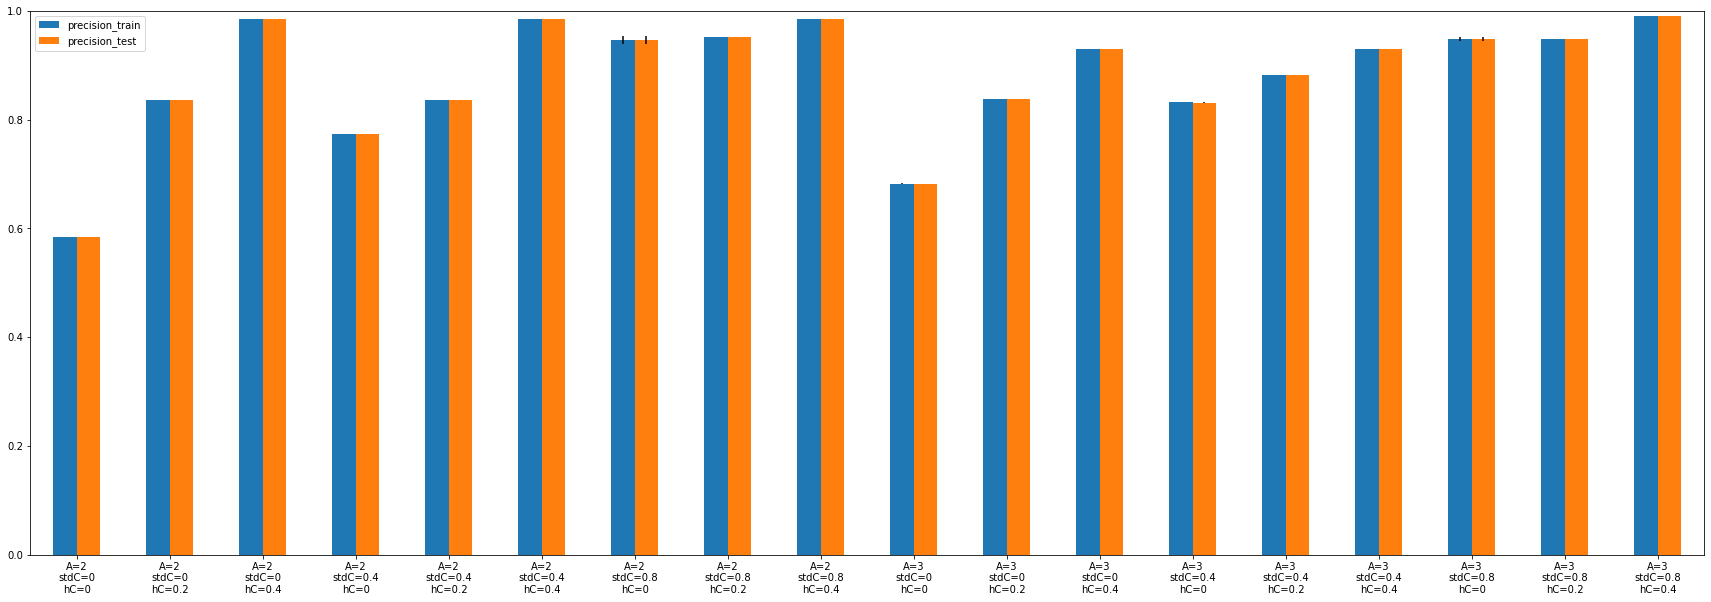

In [10]:
fig, _axs = plt.subplots(nrows=1, ncols=1, figsize=(30,10)) 
to_print, to_print_std = mean_and_std_precision(new_dfs, cv)

to_print.plot.bar(ax=_axs, rot=0, yerr=to_print_std, ylim=[0,1])

# 6° Prediction

In [11]:
to_print_save =  []
to_print_std_save = []

In [ ]:
%%time

# prediction_per_rules_count, prediction_per_rules_raw = prediction_test(root, cv, new_dfs, democracy_proportional, indexes, True)
prediction_per_rules_count, prediction_per_rules_raw, rules_used = prediction_test(root, cv, new_dfs, democracy, indexes, True)

accuracy_prediction = compute_accuracy_prediction(prediction_per_rules_raw, df, indexes)

to_print, to_print_std = mean_and_std_vote(accuracy_prediction, "Demo", cv)
to_print_save.append(to_print)
to_print_std_save.append(to_print_std)

max_possible = bestScorePossible(prediction_per_rules_count, cv)
print_accuracy(to_print_save[-1], to_print_std_save[-1], max_possible, colors_to_print)

Process n°0 : Launched
Process n°1 : Launched
Process n°2 : Launched
Process n°3 : Launched
Process n°4 : LaunchedProcess n°5 : Launched
Process n°6 : Launched
Process n°7 : Launched

Process n°8 : Launched
Process n°9 : Launched
Process n°10 : Launched
Process n°11 : Launched
Process n°12 : Launched


In [ ]:
%%time

# prediction_per_rules_count, prediction_per_rules_raw = prediction_test(root, cv, new_dfs, democracy, indexes, True)
prediction_per_rules_count, prediction_per_rules_raw, rules_used = prediction_test(root, cv, new_dfs, safe, indexes, True)

accuracy_prediction = compute_accuracy_prediction(prediction_per_rules_raw, df, indexes)

to_print, to_print_std = mean_and_std_vote(accuracy_prediction, "Safe", cv)
to_print, to_print_std = merge(to_print_save[-1], to_print, to_print_std_save[-1], to_print_std)
to_print_save.append(to_print)
to_print_std_save.append(to_print_std)

print_accuracy(to_print_save[-1], to_print_std_save[-1], max_possible, colors_to_print)

In [ ]:
%%time

prediction_per_rules_count, prediction_per_rules_raw, rules_used = prediction_test(root, cv, new_dfs, expert, indexes, True, ranking=(["precision_train", "precision_test"], [False, False]))

accuracy_prediction = compute_accuracy_prediction(prediction_per_rules_raw, df, indexes)

to_print, to_print_std = mean_and_std_vote(accuracy_prediction, "expert-precision", cv)
to_print, to_print_std = merge(to_print_save[-1], to_print, to_print_std_save[-1], to_print_std)
to_print_save.append(to_print)
to_print_std_save.append(to_print_std)

print_accuracy(to_print_save[-1], to_print_std_save[-1], max_possible, colors_to_print)

In [ ]:
rules_used

In [ ]:
%%time

prediction_per_rules_count, prediction_per_rules_raw, rules_used = prediction_test(root, cv, new_dfs, expert, indexes, True, ranking=(["headCoverage", "precision_train", "precision_test"], [True, False, False]))

accuracy_prediction = compute_accuracy_prediction(prediction_per_rules_raw, df, indexes)

to_print, to_print_std = mean_and_std_vote(accuracy_prediction, "expert-coverage", cv)
to_print, to_print_std = merge(to_print_save[-1], to_print, to_print_std_save[-1], to_print_std)
to_print_save.append(to_print)
to_print_std_save.append(to_print_std)

print_accuracy(to_print_save[-1], to_print_std_save[-1], max_possible, colors_to_print)

In [ ]:
rules_used

In [ ]:
%%time

prediction_per_rules_count, prediction_per_rules_raw, rules_used = prediction_test(root, cv, new_dfs, expert, indexes, True, ranking=(["size_hypothese", "precision_train", "precision_test"], [False, False, False]))

accuracy_prediction = compute_accuracy_prediction(prediction_per_rules_raw, df, indexes)

to_print, to_print_std = mean_and_std_vote(accuracy_prediction, "expert-length", cv)
to_print, to_print_std = merge(to_print_save[-1], to_print, to_print_std_save[-1], to_print_std)
to_print_save.append(to_print)
to_print_std_save.append(to_print_std)

print_accuracy(to_print_save[-1], to_print_std_save[-1], max_possible, colors_to_print)

In [ ]:
rules_used

In [ ]:
new_dfs['CV=0-A=2\nstdC=0\nhC=0'].info()

In [17]:
new_dfs['CV=0-A=2\nstdC=0\nhC=0'].describe()

,size_hypothese,headCoverage,stdConfidence,pcaConfidence,precision_train,precision_test
count,47.0,47.000000,47.000000,47.000000,47.000000,47.000000
mean,1.0,0.148186,0.592752,0.592752,0.592752,0.592776
std,0.0,0.077972,0.312187,0.312187,0.312187,0.312399
min,1.0,0.030150,0.120561,0.120561,0.120561,0.122609
25%,1.0,0.058156,0.231804,0.231804,0.231804,0.231422
50%,1.0,0.180317,0.716588,0.716588,0.716588,0.726912
75%,1.0,0.203305,0.814245,0.814245,0.814245,0.809525
max,1.0,0.252243,1.000000,1.000000,1.000000,1.000000


In [20]:
new_dfs['CV=0-A=2\nstdC=0\nhC=0'].sort_values("precision_train", ascending=False)

,hypotheses,conclusion,size_hypothese,headCoverage,stdConfidence,pcaConfidence,precision_train,precision_test
?a loanAmount 3 => ?a approval False,"(?a loanAmount 3,)",?a approval False,1,0.248522,1.000000,1.000000,1.000000,1.000000
?a income/yearlyReimbursement 2 => ?a approval False,"(?a income/yearlyReimbursement 2,)",?a approval False,1,0.250308,1.000000,1.000000,1.000000,1.000000
?a income/yearlyReimbursement 0 => ?a approval False,"(?a income/yearlyReimbursement 0,)",?a approval False,1,0.252243,1.000000,1.000000,1.000000,1.000000
?a income/yearlyReimbursement 1 => ?a approval False,"(?a income/yearlyReimbursement 1,)",?a approval False,1,0.247367,1.000000,1.000000,1.000000,1.000000
?a yearlyReimbursement 3 => ?a approval False,"(?a yearlyReimbursement 3,)",?a approval False,1,0.248987,1.000000,1.000000,1.000000,1.000000
?a yearlyReimbursement 2 => ?a approval False,"(?a yearlyReimbursement 2,)",?a approval False,1,0.249392,1.000000,1.000000,1.000000,1.000000
?a loanAmount 2 => ?a approval False,"(?a loanAmount 2,)",?a approval False,1,0.249812,1.000000,1.000000,1.000000,1.000000
?a income 0 => ?a approval False,"(?a income 0,)",?a approval False,1,0.235892,0.943088,0.943088,0.943088,0.940060
?a monthDuration 0 => ?a approval False,"(?a monthDuration 0,)",?a approval False,1,0.229727,0.916243,0.916243,0.916243,0.920426
?a income/yearlyReimbursement 3 => ?a approval True,"(?a income/yearlyReimbursement 3,)",?a approval True,1,0.219932,0.879439,0.879439,0.879439,0.877391
